In [68]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

In [72]:
cities_matrix = pd.read_csv('../data/macedonia_travel_time_matrix_all_cities_only.csv',index_col=0)
cities_cords = pd.read_csv('../data/mk.csv')

In [73]:
cities_matrix.head()

,Skopje,Kumanovo,Bitola,Prilep,Tetovo,Štip,Veles,Ohrid,Strumica,Gostivar,...,Radoviš,Kruševo,Makedonski Brod,Demir Kapija,Bogdanci,Demir Hisar,Valandovo,Pehčevo,Makedonska Kamenica,Resen
Skopje,0.0,37.7,167.5,120.0,41.3,61.4,58.8,180.4,125.8,63.5,...,91.4,169.8,152.8,92.9,128.0,174.0,122.7,137.4,102.3,196.1
Kumanovo,36.7,0.0,164.0,116.5,64.4,54.9,55.3,203.5,119.3,86.6,...,84.9,166.3,160.8,89.5,124.5,170.5,119.2,130.9,95.7,192.6
Bitola,157.2,152.9,0.0,52.9,175.9,152.4,122.5,80.9,189.2,153.6,...,176.4,69.5,95.9,123.3,158.4,32.3,153.1,228.4,193.2,36.8
Prilep,108.9,104.6,53.0,0.0,135.4,104.1,74.2,125.7,140.9,137.2,...,128.1,50.9,45.4,75.0,110.1,59.5,104.8,180.1,144.9,81.6
Tetovo,43.2,66.5,176.2,148.4,0.0,90.2,87.2,145.3,154.6,28.4,...,120.2,158.6,117.7,121.3,156.4,144.1,151.1,166.2,131.1,187.8


In [74]:
cities_cords.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Skopje,41.9961,21.4317,North Macedonia,MK,Skopje,primary,526502.0,526502.0
1,Kumanovo,42.1322,21.7144,North Macedonia,MK,Kumanovo,admin,70842.0,70842.0
2,Bitola,41.0319,21.3347,North Macedonia,MK,Bitola,admin,69287.0,69287.0
3,Prilep,41.3464,21.5542,North Macedonia,MK,Prilep,admin,63308.0,63308.0
4,Tetovo,42.0103,20.9714,North Macedonia,MK,Tetovo,admin,63176.0,63176.0


In [76]:
# Keep only first three columns: ['City', 'lat', 'lon'] - drop any extra columns
cities_cords.drop(cities_cords.columns[3:], axis=1, inplace=True)
cities_cords = cities_cords[cities_cords["city"].isin(cities_matrix.columns)].copy()

In [77]:
cities_cords.head(11)

,city,lat,lng
0,Skopje,41.9961,21.4317
1,Kumanovo,42.1322,21.7144
2,Bitola,41.0319,21.3347
3,Prilep,41.3464,21.5542
4,Tetovo,42.0103,20.9714
5,Štip,41.7358,22.1914
6,Veles,41.7153,21.7753
7,Ohrid,41.1169,20.8019
8,Strumica,41.4375,22.6431
9,Gostivar,41.8000,20.9167


In [78]:
cities_cords.shape

(34, 3)

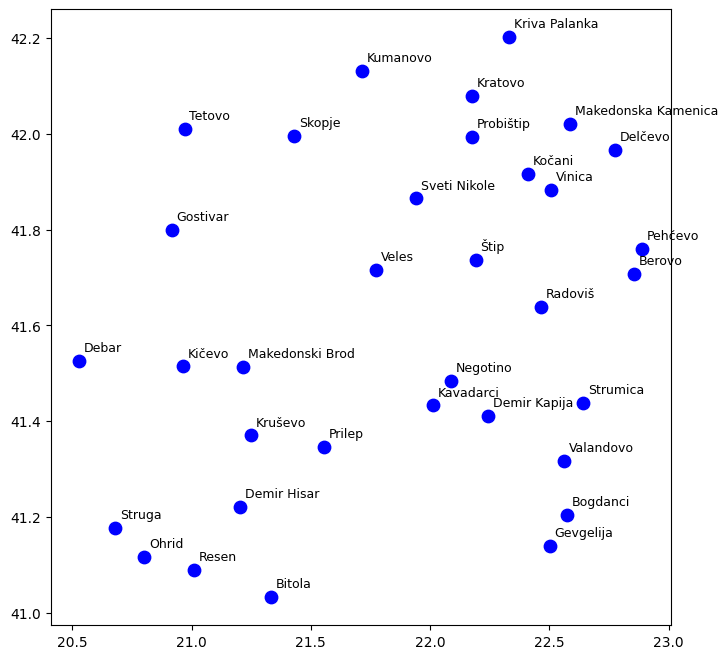

In [80]:
plt.figure(figsize=(8, 8))

plt.scatter(cities_cords["lng"], cities_cords["lat"], c="blue", s=80)

for _, row in cities_cords.iterrows():
    plt.text(row["lng"] + 0.02, row["lat"] + 0.02, row["city"], fontsize=9)

plt.show()


In [85]:
import matplotlib.pyplot as plt

def plot_route(coords_df, route, total_time, iteration=None):
    """
    Plots the route connecting cities in the order given by the route list.

    coords_df: DataFrame with columns ['city', 'lat', 'lng']
              (index can be anything)
    route: list/array of integer positions into coords_df (0..n-1)
    total_time: total travel time for the route
    iteration: optional iteration number
    """
    plt.figure(figsize=(8, 8))

    # Plot all cities
    plt.scatter(coords_df["lng"], coords_df["lat"], c="blue", s=80)

    # Use iloc so we index by position, not by label
    for i in range(len(coords_df)):
        plt.text(
            coords_df["lng"].iloc[i] + 0.02,
            coords_df["lat"].iloc[i] + 0.02,
            coords_df["city"].iloc[i],
            fontsize=9
        )

    # Draw route path
    for i in range(len(route) - 1):
        city1 = coords_df.iloc[int(route[i])]
        city2 = coords_df.iloc[int(route[i + 1])]
        plt.plot([city1["lng"], city2["lng"]], [city1["lat"], city2["lat"]], "r-", lw=2)

    # Connect last to first (return trip)
    city1 = coords_df.iloc[int(route[-1])]
    city2 = coords_df.iloc[int(route[0])]
    plt.plot([city1["lng"], city2["lng"]], [city1["lat"], city2["lat"]], "r--", lw=2)

    title = f"Best Route (Time: {total_time:.2f} minutes)"
    if iteration is not None:
        title += f" - Iteration {iteration}"
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()


In [82]:
# ========================================
# Ant Colony Optimization Initialization
# ========================================

def initialize_pheromone(num_cities, tau0=1.0):
    """
    Initializes the pheromone matrix with a base value tau0.
    """
    return np.ones((num_cities, num_cities)) * tau0


def select_next_city(probabilities):
    """
    Selects the next city based on transition probabilities.
    """
    return np.random.choice(range(len(probabilities)), p=probabilities)


def calculate_probabilities(current_city, unvisited, pheromone, distances, alpha, beta):
    """
    Calculates the probability of moving from the current city to each of the unvisited ones.
    """
    tau = np.take(pheromone[current_city], unvisited)
    eta = 1 / np.take(distances[current_city], unvisited)
    
    # Transition rule
    probs = (tau ** alpha) * (eta ** beta)
    probs /= probs.sum()
    return probs


In [83]:
# ========================================
# Main Ant Colony Optimization Procedure
# ========================================

def ant_colony_optimization(dist_df, coords_df, n_ants=20, n_iterations=100,
                            alpha=1, beta=3, evaporation_rate=0.5, Q=100):
    """
    Runs the Ant Colony Optimization to minimize total travel time.
    
    Parameters:
    - dist_df: Pandas DataFrame containing travel times (minutes) between cities
    - coords_df: DataFrame with ['City', 'lat', 'lon']
    """
    cities = dist_df.index.tolist()
    num_cities = len(cities)
    dist_matrix = dist_df.to_numpy()
    pheromone = initialize_pheromone(num_cities)
    
    best_route = None
    best_time = float('inf')
    
    for iteration in range(n_iterations):
        all_routes = []
        all_times = []
        
        for ant in range(n_ants):
            visited = [random.randint(0, num_cities - 1)]
            unvisited = list(set(range(num_cities)) - set(visited))
            
            while unvisited:
                current_city = visited[-1]
                probs = calculate_probabilities(current_city, unvisited, pheromone, dist_matrix, alpha, beta)
                next_city = unvisited[select_next_city(probs)]
                visited.append(next_city)
                unvisited.remove(next_city)
            
            # Complete the tour (return to start)
            total_time = sum(dist_matrix[visited[i], visited[i+1]] for i in range(len(visited)-1))
            total_time += dist_matrix[visited[-1], visited[0]]
            
            all_routes.append(visited)
            all_times.append(total_time)
            
            if total_time < best_time:
                best_time = total_time
                best_route = visited
        
        # Evaporation
        pheromone *= (1 - evaporation_rate)
        
        # Deposit pheromones
        for route, time in zip(all_routes, all_times):
            for i in range(len(route) - 1):
                pheromone[route[i], route[i+1]] += Q / time
            pheromone[route[-1], route[0]] += Q / time  # close the loop
        
        # Visualize progress
        if iteration % 100 == 0 or iteration == n_iterations - 1:
            print(f"Iteration {iteration+1}/{n_iterations}: Best time = {best_time:.2f} minutes")
            # plot_route(coords_df, best_route, best_time, iteration)
    
    return best_route, best_time


Iteration 1/100: Best time = 1642.90 minutes
Iteration 100/100: Best time = 1276.30 minutes

✅ FINAL BEST ROUTE:
Demir Kapija -> Negotino -> Kavadarci -> Prilep -> Kruševo -> Demir Hisar -> Bitola -> Resen -> Ohrid -> Struga -> Debar -> Kičevo -> Makedonski Brod -> Gostivar -> Tetovo -> Skopje -> Kumanovo -> Kriva Palanka -> Kratovo -> Probištip -> Kočani -> Vinica -> Makedonska Kamenica -> Delčevo -> Pehčevo -> Berovo -> Strumica -> Radoviš -> Štip -> Sveti Nikole -> Veles -> Gevgelija -> Bogdanci -> Valandovo
Total Travel Time: 1276.30 minutes


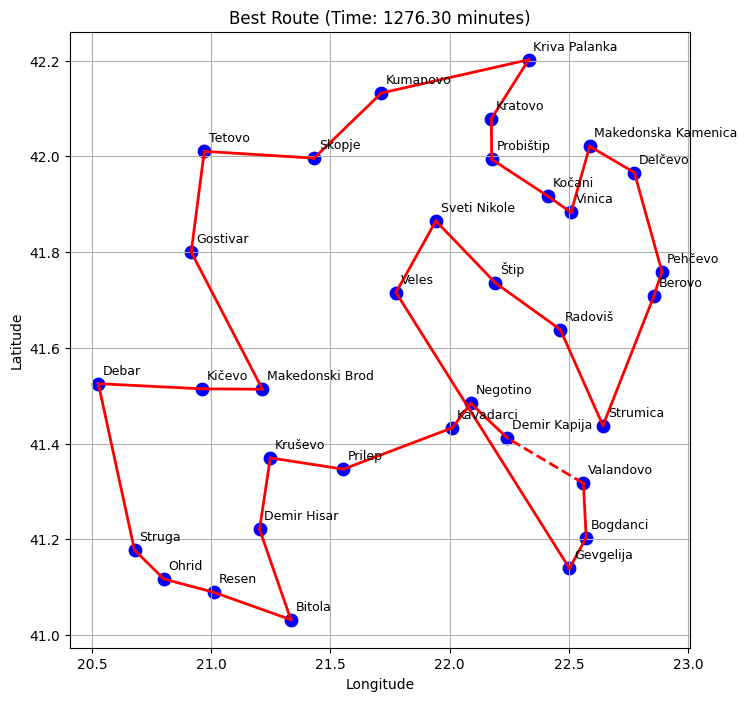

In [86]:
# ========================================
# Run the ACO Simulation
# ========================================

best_route, best_time = ant_colony_optimization(
    dist_df=cities_matrix,        
    coords_df=cities_cords,    
    n_ants=75,
    n_iterations=100,
    alpha=1,
    beta=3,
    evaporation_rate=0.4,
    Q=500
)

print("\n✅ FINAL BEST ROUTE:")
print(" -> ".join(cities_cords['city'].iloc[best_route]))
print(f"Total Travel Time: {best_time:.2f} minutes")

plot_route(cities_cords, best_route, best_time)


Starting randomized search with 10 trials...

Trial 1/10 with params: {'alpha': 2.779133777427007, 'beta': 7.809803218260476, 'rho': 0.8936380777033021, 'Q': 48.49750728940154, 'n_ants': 28, 'n_iterations': 57}
Iteration 1/57: Best time = 1455.70 minutes
Iteration 57/57: Best time = 1283.30 minutes
Trial 2/10 with params: {'alpha': 2.8916798198258142, 'beta': 1.8187656740909093, 'rho': 0.23409284292995924, 'Q': 3.7438773529768206, 'n_ants': 26, 'n_iterations': 90}
Iteration 1/90: Best time = 2209.20 minutes
Iteration 90/90: Best time = 1286.30 minutes
Trial 3/10 with params: {'alpha': 1.5295682020012362, 'beta': 2.2393341884224296, 'rho': 0.6760148352388983, 'Q': 73.78700272080135, 'n_ants': 33, 'n_iterations': 90}
Iteration 1/90: Best time = 1914.20 minutes
Iteration 90/90: Best time = 1300.50 minutes
Trial 4/10 with params: {'alpha': 2.9944361720883865, 'beta': 5.515585979341005, 'rho': 0.20471156603716834, 'Q': 39.65799314926585, 'n_ants': 38, 'n_iterations': 59}
Iteration 1/59: Bes

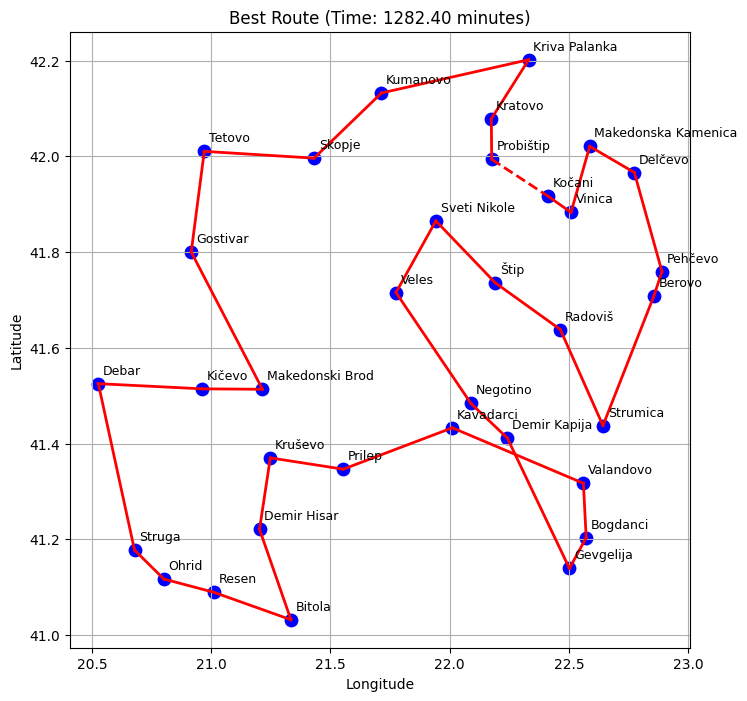

In [87]:

def random_search_aco(distance_df, coords, param_space, n_trials=15):
    """
    Perform a randomized hyperparameter search for Ant Colony Optimization.
    distance_df : pandas DataFrame (distance/time matrix)
    coords : list of (lat, lon) for plotting
    param_space : dict of parameter ranges
    n_trials : how many random combinations to test
    """
    results = []
    print(f"Starting randomized search with {n_trials} trials...\n")
    
    for i in range(n_trials):
        # Randomly sample parameters from ranges
        params = {
            k: random.uniform(v[0], v[1]) if isinstance(v, tuple) else random.choice(v)
            for k, v in param_space.items()
        }
        params['n_ants'] = int(params['n_ants'])
        params['n_iterations'] = int(params['n_iterations'])
        
        print(f"Trial {i+1}/{n_trials} with params: {params}")
        
        best_route, best_time = ant_colony_optimization(
            distance_df,
            coords,
            n_ants=params['n_ants'],
            n_iterations=params['n_iterations'],
            alpha=params['alpha'],
            beta=params['beta'],
            evaporation_rate=params['rho'],
            Q=params['Q']
        )
        
        results.append({
            'params': params,
            'best_time': best_time,
            'best_route': best_route
        })
    
    # Find the best trial
    results_df = pd.DataFrame(results)
    best_trial = results_df.loc[results_df['best_time'].idxmin()]
    best_params = best_trial['params']
    best_route = best_trial['best_route']
    best_time = best_trial['best_time']
    
    print("\n Best parameters found:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print(f" Best route time: {best_trial['best_time']:.2f} minutes")

    plot_route(coords, best_route, best_time)

    return best_params, results_df


# Example parameter search space
param_space = {
    'alpha': (0.5, 3.0),          
    'beta': (1.0, 10.0),          
    'rho': (0.1, 0.9),           
    'Q': (1, 100),                
    'n_ants': (10, 40),         
    'n_iterations': (50, 150)   
}


best_params, search_results = random_search_aco(cities_matrix, cities_cords, param_space, n_trials=10)
